In [119]:
from __future__ import print_function
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import cdist
import math
import pylab as pl

In [120]:
words,defs = pickle.load(open("train_data_filtered.pkl", "rb" ),encoding='latin1')
word_embs = pickle.load(open("../embeddings/D_cbow_pdw_8B.pkl", "rb" ),encoding='latin1')
#Based on https://stackoverflow.com/questions/32957708/python-pickle-error-unicodedecodeerror

In [121]:
#Selecting subset of data
training_words = words[:1000]
training_defs = defs[:1000]

In [122]:
#Create vocab
def create_vocab(words,defs):
    x_vocab = {}
    y_vocab = {}
    x_idx = 0
    y_idx = 0
    for word in words:
        if word not in y_vocab:
            y_vocab[word] = y_idx
            y_idx += 1

    for word_def in defs:
        for word in word_def:
            if word not in x_vocab:
                x_vocab[word] = x_idx
                x_idx += 1
    x_vocab['<pad>'] = x_idx #Pad token is last index useed for masking
    y_vocab['<pad>'] = y_idx #Pad token is last index useed for masking
    print('Unique words found in x_vocab ',len(x_vocab))
    print('Unique words found in y_vocab ',len(y_vocab))
    return x_vocab,y_vocab

In [123]:
X_vocab,Y_vocab = create_vocab(training_words,training_defs)

Unique words found in x_vocab  2739
Unique words found in y_vocab  75


In [124]:
#Hyper params definition (from paper)
vocab_len = len(X_vocab)
max_len = 16 #Number of timesteps
input_emb_dim = 500 #Dimension of learned input embeddings
output_emb_dim = 500 #Standard dim of output provided
lstm_units = 512
batch_size = 16
epochs = 10
train_val_split = 0.85 #85% train, 15% validation

In [125]:
training_x = [[X_vocab[word] for word in word_def] for word_def in training_defs]
training_y = [Y_vocab[word] for word in training_words]
#Pad sequences, prepare training data
X = np.ones((len(training_x), max_len)) * 0
for i in range(len(training_x)):
    seq = training_x[i]
    seq_len = min(len(seq),max_len)
    X[i,0:seq_len] = seq[0:seq_len]
Y = np.array(training_y)
data_set = []
for i in range(len(training_x)):
    data_set.append((X[i],Y[i]))

In [126]:
#Split dataset into training and validation set
np.random.shuffle(data_set)
val_idx = math.floor(train_val_split*len(data_set))
print(val_idx)
train_set = data_set[:val_idx]
val_set = data_set[val_idx:]

850


In [127]:
class BatchIterator:

    """Iterator that returns batches of fixed sizes for specified epochs"""

    def __init__(self, data_set, batch_size, epochs):
        self.data_set = data_set
        self.start_idx = 0
        self.epochs = epochs
        self.batch_size = batch_size
        self.len_data_set = len(self.data_set)
        self.current_epoch = 1
        self.current_batch = 1       
        self.batches_per_epoch = math.ceil(self.len_data_set/self.batch_size)
        print(self.len_data_set)
        print(self.batches_per_epoch)
        np.random.shuffle(self.data_set)
    def has_ended(self):
        return self.current_epoch > self.epochs
    
    def __iter__(self):
        return self

    def __next__(self):
        #print('Current start index '+str(self.start_idx))
        #print('Current epoch, current batch '+str(self.current_epoch)+' , '+str(self.current_batch))
        batch = []
        i = self.start_idx
        end = min(self.len_data_set-1,i+self.batch_size-1)
        #print(end)
        while(i <= end):
            batch.append(self.data_set[i])
            i += 1
        #If can't find enough data points till the end of list, start from zero again
        if(len(batch) < self.batch_size):
            #print('Over shot the length of the list')
            i = 0
            while(len(batch) != self.batch_size):
                batch.append(self.data_set[i]) 
                i += 1
        self.start_idx = i
        
        #Increment epoch, reset variables, reshuffle the dataset
        if(self.current_batch == self.batches_per_epoch):
            self.current_epoch += 1            
            self.current_batch = 1
            #Shuffle the list, reset start idx
            np.random.shuffle(self.data_set)
            self.start_idx = 0
        else:
            self.current_batch += 1
        return batch

In [128]:
#Create embedding matrix
embedding_matrix = np.zeros((vocab_len, output_emb_dim))
for word, i in X_vocab.items():
    embedding_vector = word_embs.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        print('Embedding not found')
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(output_emb_dim, ))
print("Embedding matrix created!")

Embedding not found
Embedding matrix created!


In [129]:
class PolicyEstimator(nn.Module):

    def __init__(self, weight_matrix, embedding_dim, hidden_dim, vocab_size, tagset_size, seq_len, batch_size):
        super(PolicyEstimator, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.tagset_size = tagset_size
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        #self.word_embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        #Load pretrained word embeddings
        self.word_embeddings = nn.Embedding.from_pretrained(weight_matrix)
        #Trainable false
        self.word_embeddings.weight.requires_grad = False
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, self.batch_size, self.hidden_dim),
                torch.zeros(1, self.batch_size, self.hidden_dim))
    
    def predict(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        X = lstm_out.contiguous()
        X = X.view(-1, X.shape[2])
        tag_space = self.hidden2tag(X)
        tag_scores = F.softmax(tag_space, dim=1) #Return softmax here!
        Y_hat = tag_scores.view(self.batch_size, self.seq_len, self.tagset_size)
        return tag_space, Y_hat

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        X = lstm_out.contiguous()
        X = X.view(-1, X.shape[2])
        tag_space = self.hidden2tag(X)
        tag_scores = F.log_softmax(tag_space, dim=1) #Return log softmax for forward function!
        Y_hat = tag_scores.view(self.batch_size, self.seq_len, self.tagset_size)
        return Y_hat

In [130]:
# points should have embeddings of all output words in a list
#Normalize output word embeddings to unit vectors
def normalize_vocab(voc):
    points = [None]*(len(voc))
    for w, idx in voc.items():
        points[idx] = embedding_matrix[idx]/np.linalg.norm(embedding_matrix[idx])
    points = np.array(points)
    return points

In [131]:
points = normalize_vocab(Y_vocab)

In [132]:
def get_pred_rank (pred_idx, label_idx, points):
    dist_list = cdist(points, np.array([points[pred_idx]]), 'cosine').flatten() #Convert 2d into 1d array
    #result_indices = np.argpartition(dist_list, k)[:k]
    #if label_idx in result_indices:
    #    return True
    #return False
    result_indices = list(np.argsort(dist_list))
    return result_indices.index(label_idx)

In [133]:
def get_reward_for_action(action,target):
    #Using inverse rank as reward
    rank = get_pred_rank(action, target, points) + 1
    return 1/rank

In [134]:
def train(policy_estimator, data_iterator):
    # Define optimizer
    optimizer = optim.Adam(policy_estimator.parameters(),lr=0.01)
    total_rewards = []
    counter = 0
    loss_freq = 10 #Print loss every 10 batches
    val_freq = 100 #Print validation accuracy every 100 batches
    #Save model based on some acc threshold
    losses=[]
    while(not data_iterator.has_ended()):
        policy_estimator.hidden = policy_estimator.init_hidden()
        action_space = np.arange(policy_estimator.tagset_size)
        
        #Get next batch
        batch_data = next(data_iterator)
        counter += 1
        batch_rewards = []
        batch_actions = []
        batch_states = [sequence[0] for sequence in batch_data]
        state_tensor = torch.tensor(batch_states, dtype=torch.long)
        
        _, batch_out = policy_estimator.predict(state_tensor)
        
        batch_out = batch_out.detach().numpy()
        for i in range(len(batch_data)):
            #Iterate over each LSTM time step
            actions = []
            rewards = []
            target = batch_data[i][1] #Get label of the current sequence
            for j in range(batch_out[i].shape[0]):
                action_probs = batch_out[i][j]
                action = np.random.choice(action_space, p=action_probs)
                actions.append([action]) #To have 1 dimension at the end for indexing
                reward = get_reward_for_action(action,target)
                rewards.append(reward)                   
            batch_actions.append(actions)
            batch_rewards.append(np.mean(rewards)) #Append average reward per time step to batch_rewards                   
        total_rewards.append(sum(batch_rewards)) #Total of rewards for a batch
        reward_tensor = torch.FloatTensor(batch_rewards)
        
        action_tensor = torch.LongTensor(batch_actions)

        #Gradient update
        optimizer.zero_grad()

        # Calculate loss
        logprob = policy_estimator(state_tensor)
        
        '''
        Dimensionality check
        logprob = batch_size * max_len * tagset_size(output_vocab_dim)
        reward_tensor = batch_size * max_len
        action_tensor = batch_size * max_len * 1 (3d tensor so that I can do the gather operation)
        '''
        
        selected_logprobs = torch.gather(logprob,2,action_tensor)
        #Reshape so that dot product can be computed
        selected_logprobs = selected_logprobs.view(selected_logprobs.shape[0],selected_logprobs.shape[1])
        selected_logprobs = reward_tensor * selected_logprobs
        
        loss = -selected_logprobs.mean(1).sum() #Take mean of timestep for loss per seq, sum for all seq in batch
        
        losses.append(loss.item())
        if(counter % loss_freq == 0):
            print("\rEpoch : {}, Batch count: {} Current Loss: {:.4f} Rewards of last 10 batches: {:.2f}".format(
                data_iterator.current_epoch, counter, loss, np.mean(total_rewards[-10:]) ))

        # Calculate gradients
        loss.backward()

        # Apply gradients
        optimizer.step()
    return losses

In [135]:
# Initialize weight matrix tensor from embedding matrix
weight_matrix = torch.FloatTensor(embedding_matrix)

In [136]:
# Initialize dataIterator
batchIterator = BatchIterator(train_set, batch_size, 4)

850
54


In [137]:
# Initialize model
model = PolicyEstimator(weight_matrix, input_emb_dim, lstm_units, len(X_vocab), len(Y_vocab), max_len, batch_size)

In [138]:
output_losses = train(model, batchIterator)

Epoch : 1, Batch count: 10 Current Loss: 1.4277 Rewards of last 10 batches: 1.21
Epoch : 1, Batch count: 20 Current Loss: 0.9788 Rewards of last 10 batches: 1.02
Epoch : 1, Batch count: 30 Current Loss: 0.2887 Rewards of last 10 batches: 1.04
Epoch : 1, Batch count: 40 Current Loss: 0.5445 Rewards of last 10 batches: 1.52
Epoch : 1, Batch count: 50 Current Loss: 0.0453 Rewards of last 10 batches: 1.14
Epoch : 2, Batch count: 60 Current Loss: 0.0543 Rewards of last 10 batches: 1.09
Epoch : 2, Batch count: 70 Current Loss: 0.0514 Rewards of last 10 batches: 1.29
Epoch : 2, Batch count: 80 Current Loss: 0.0176 Rewards of last 10 batches: 1.04
Epoch : 2, Batch count: 90 Current Loss: 0.0436 Rewards of last 10 batches: 0.89
Epoch : 2, Batch count: 100 Current Loss: 0.2733 Rewards of last 10 batches: 0.75
Epoch : 3, Batch count: 110 Current Loss: 0.2052 Rewards of last 10 batches: 0.98
Epoch : 3, Batch count: 120 Current Loss: 0.0258 Rewards of last 10 batches: 0.96
Epoch : 3, Batch count: 1

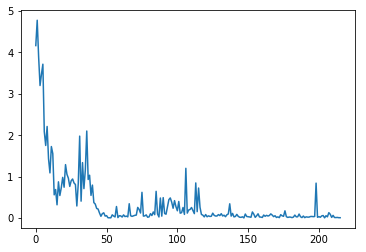

In [139]:
#Plot output losses
pl.plot(output_losses)